In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 12.9 GB  I Proc size: 139.3 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
!pip install torch torchvision tensorboardX

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59118000 @  0x7f48ac05d2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 22.8MB/s 
    100% |████████████████████████████████| 71kB 25.1MB/s 
    100% |████████████████████████████████| 2.0MB 5.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
from google.colab import files
uploaded = files.upload()

Saving skipgramstate.tar.gz to skipgramstate.tar.gz


In [0]:
!ls -lh
!du -hd1
#!mv 'skipgramstate.tar (1).gz' skipgramstate.tar.gz

total 52M
drwxr-xr-x 2 root root 4.0K Nov  7 20:08 sample_data
-rw-r--r-- 1 root root  52M Nov 12 17:22 skipgramstate.tar.gz
55M	./sample_data
76K	./.config
106M	.


In [0]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import pickle
import os
import random
from collections import defaultdict
import itertools
from timeit import default_timer as timer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [0]:
!tar -xzvf skipgramstate.tar.gz

data/
data/acid_properties.csv
data/nice_embed_tsne.csv
data/family_classification_metadata.tab
data/family_classification_sequences.tab
models/
models/model_2000.pth
models/model_1000000.pth


In [0]:
!ls -lh data
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

total 165M
-rw-rw-r-- 1 1000 users  563 Aug  2  2017 acid_properties.csv
-rw-rw-r-- 1 1000 users  32M Aug  3  2017 family_classification_metadata.tab
-rw-rw-r-- 1 1000 users 133M Aug  3  2017 family_classification_sequences.tab
-rw-rw-r-- 1 1000 users 398K Aug  2  2017 nice_embed_tsne.csv


,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [0]:
counter = itertools.count()
cod2id = defaultdict(lambda: next(counter))

def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cod2id[cropped_seq[i:i+3]] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [0]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [0]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

saving data/all_codones.pickle


In [0]:
!ls -lh data

total 559M
-rw-rw-r-- 1 1000 users  563 Aug  2  2017 acid_properties.csv
-rw-r--r-- 1 root root  394M Nov 12 17:25 all_codones.pickle
-rw-rw-r-- 1 1000 users  32M Aug  3  2017 family_classification_metadata.tab
-rw-rw-r-- 1 1000 users 133M Aug  3  2017 family_classification_sequences.tab
-rw-rw-r-- 1 1000 users 398K Aug  2  2017 nice_embed_tsne.csv


In [0]:
######################

In [0]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target

def get_batch(iterator, batch_size, to_skip=0):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    for _ in range(to_skip * batch_size):
        next(iterator)
    while True:
        center_batch = torch.zeros(batch_size, dtype=torch.long)
        target_batch = torch.zeros(batch_size, dtype=torch.long)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch.cuda(), target_batch.cuda()

def flatten(x):
    return [item for sublist in x for item in sublist]

def count_codones(all_codones):
    return np.bincount(flatten(all_codones))

def process_data(all_codones, batch_size, skip_window, to_skip=0):
    single_gen = generate_sample(all_codones, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size, to_skip=to_skip)
    return batch_gen

In [0]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

In [0]:
######################

In [0]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.embed = nn.Embedding(vocab_size, embed_size, sparse=True)
        self.embed_aux = nn.Embedding(vocab_size, embed_size, sparse=True)
        self.embed.weight.data.uniform_(-0.5 / self.embed_size,
                                        0.5 / self.embed_size)
#         self.embed_aux.weight.data.uniform_(-0.5 / self.embed_size,
#                                         0.5 / self.embed_size)
        
    def forward(self, in_words, out_words, sampled_words):
        in_words = self.embed(in_words)
        out_words = self.embed_aux(out_words)
        sampled_words = self.embed_aux(sampled_words)
        
        # batch dot product; torch.bmm is said to be slower for this task
        losses = F.logsigmoid((in_words * out_words).sum(dim=1))
        sampled_losses = F.logsigmoid(torch.bmm(-sampled_words,
                                                in_words.unsqueeze(-1))
                                      .squeeze(dim=2)).sum(dim=1)
        
        return -(losses + sampled_losses).mean()

In [0]:
######################

In [0]:
p = np.array(count_codones(all_codones))
p = p**0.75
p /= p.sum()

def neg_sample(size):
    return np.random.choice(len(cod2id), size=size, p=p)

In [0]:
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .1
N_STEPS = 2000000
N_DEBUG_OUTPUT_STEPS = N_STEPS / 1000
START_STEP = 1000000
random.seed(117)  # to reproduce batches
batch_gen = process_data(all_codones, BATCH_SIZE, SKIP_WINDOW, to_skip=START_STEP)

In [0]:
def train(model, optimizer, batch_gen):
    start_time = timer()
    writer = SummaryWriter()
    for t, batch in itertools.islice(enumerate(batch_gen), N_STEPS):
        in_words, out_words = batch
        sampled_words = in_words.new_tensor(
            neg_sample((*in_words.size(), NUM_SAMPLED)))
        
        optimizer.zero_grad()
        loss = model(in_words, out_words, sampled_words)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Loss', -loss, START_STEP + t)
        if (t + 1) % N_DEBUG_OUTPUT_STEPS == 0:
            print('Step {}, current loss is {:.3f}, time spent: {:.3f} seconds'
                  .format(START_STEP + t + 1, -loss.item(), timer() - start_time))
    writer.add_text('finish_time',
                    ('Learning finished in {:.3f} seconds from step {}' + 
                     ' to step {}')
                    .format(timer() - start_time, START_STEP, N_STEPS))
    writer.add_embedding(model.embed.weight)
    
    writer.close()

In [0]:
model = SkipGram(len(cod2id), EMBED_SIZE)
if os.path.exists('models/model_{}.pth'.format(START_STEP)):
    print('Loading model from', 'models/model_{}.pth'.format(START_STEP))
    model.load_state_dict(torch.load('models/model_{}.pth'.format(START_STEP)))
model = model.cuda()
train(model, torch.optim.SGD(model.parameters(), lr=LEARNING_RATE), batch_gen)
torch.save(model.state_dict(), 'models/model_{}.pth'.format(START_STEP + N_STEPS))

Loading model from models/model_1000000.pth
Step 2000, current loss is -2.770, time spent: 61.184 seconds
Step 4000, current loss is -2.749, time spent: 72.883 seconds
Step 6000, current loss is -2.793, time spent: 84.571 seconds
Step 8000, current loss is -2.958, time spent: 96.324 seconds
Step 10000, current loss is -2.651, time spent: 108.055 seconds
Step 12000, current loss is -2.761, time spent: 119.965 seconds
Step 14000, current loss is -2.563, time spent: 131.731 seconds
Step 16000, current loss is -2.794, time spent: 143.471 seconds
Step 18000, current loss is -2.876, time spent: 155.462 seconds
Step 20000, current loss is -2.594, time spent: 167.187 seconds
Step 22000, current loss is -2.754, time spent: 178.922 seconds
Step 24000, current loss is -2.718, time spent: 190.642 seconds
Step 26000, current loss is -2.737, time spent: 202.383 seconds
Step 28000, current loss is -2.757, time spent: 214.121 seconds
Step 30000, current loss is -2.513, time spent: 225.846 seconds
Step

KeyboardInterrupt: ignored

In [0]:
# Serialization
# !ls  -lh
# !ls -lh models
# !rm data/all_codones.pickle  # creating every time is faster than uploading
!tar -czvf skipgramstate.tar.gz runs models
!ls  -lh

runs/
runs/Nov12_17-26-07_6c79a2c11415/
runs/Nov12_17-26-07_6c79a2c11415/events.out.tfevents.1542043567.6c79a2c11415
^C


KeyboardInterrupt: ignored

In [0]:
files.download('skipgramstate.tar.gz')

In [0]:
print(model.embed.weight)

Parameter containing:
tensor([[ 0.1032, -0.1676,  0.1848,  ..., -0.0641, -0.0734,  0.2035],
        [ 0.0684, -0.1012,  0.0565,  ..., -0.0469, -0.0404,  0.0678],
        [ 0.0903, -0.0362,  0.1164,  ...,  0.0119,  0.0018,  0.1089],
        ...,
        [ 0.0021, -0.0009, -0.0021,  ...,  0.0001,  0.0028, -0.0023],
        [-0.0005,  0.0015, -0.0004,  ..., -0.0021, -0.0029, -0.0009],
        [-0.0036, -0.0029,  0.0024,  ..., -0.0024,  0.0012,  0.0043]],
       device='cuda:0', requires_grad=True)


In [0]:
######################

In [0]:
from timeit import default_timer as timer
with torch.no_grad():
    st = timer()
    tsne = TSNE(n_components=2, random_state=42)
    XX = tsne.fit_transform(model.embed.weight)
    print('t-SNE finished in {:.3f} seconds'.format(timer() - st))

t-SNE finished in 316.682 seconds


In [0]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(cod2id, key=cod2id.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,15.116770,36.194485,MAF
1,37.434536,9.865021,SAE
2,-16.883366,7.728123,DVL
3,14.151846,-2.190402,KEY
4,-18.957411,-6.557218,DRR


In [0]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('Unlabeled Encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

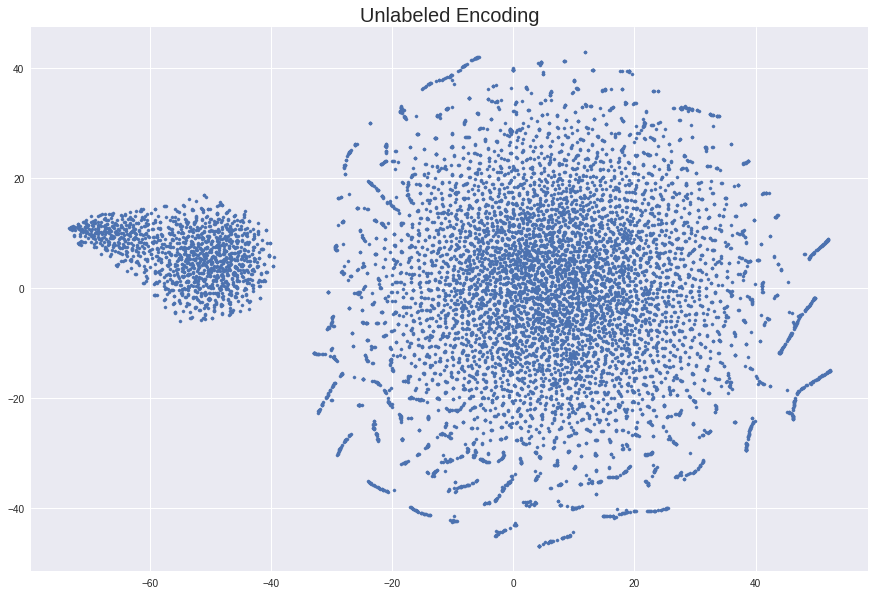

In [0]:
plot_tsne_df(tsne_df)

In [0]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [0]:
######################

In [0]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [0]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [0]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,MAF,2.166667,116.482633,18.666667,147.133333
1,SAE,-0.833333,95.756400,15.333333,105.333333
2,DVL,1.500000,109.125367,19.000000,139.266667
3,KEY,-2.900000,140.153200,22.333333,166.866667
4,DRR,-4.166667,142.486267,22.666667,152.633333


In [0]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,MAF,2.166667,116.482633,18.666667,147.133333,15.116770,36.194485
1,SAE,-0.833333,95.756400,15.333333,105.333333,37.434536,9.865021
2,DVL,1.500000,109.125367,19.000000,139.266667,-16.883366,7.728123
3,KEY,-2.900000,140.153200,22.333333,166.866667,14.151846,-2.190402
4,DRR,-4.166667,142.486267,22.666667,152.633333,-18.957411,-6.557218


In [0]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

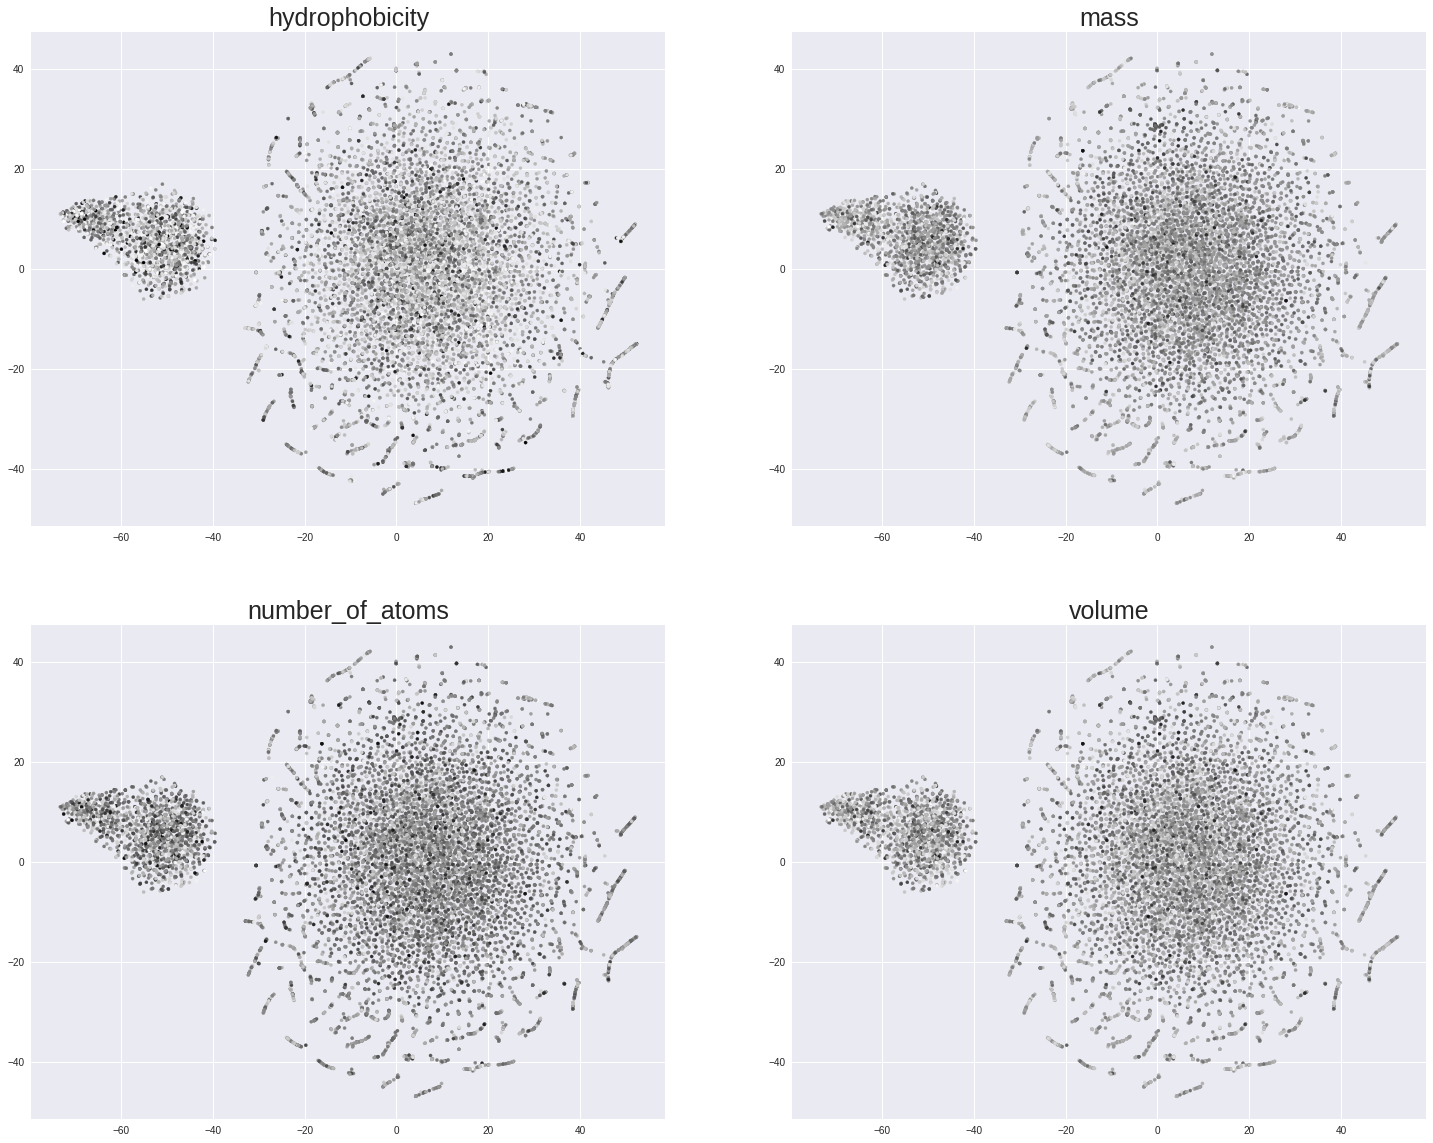

In [0]:
plot_embedding_properties(final_df)

# End of homework
================================

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_embedding_properties(final_df)

In [0]:
######################

In [0]:
# OLD, LEFT FOR COMPARISON
# filename = 'data/nice_embed_tsne.csv'
# gensim_tsne_df = pd.read_csv(filename, index_col=0)
# gensim_tsne_df.columns = ['x0', 'x1', 'codone']

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_tsne_df(gensim_tsne_df)

In [0]:
# OLD, LEFT FOR COMPARISON
# final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [0]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59